In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

2025-02-04 17:21:38.376712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-04 17:21:39.548833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Optional: Set memory growth for GPU if using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Memory growth must be set at program startup


2025-02-04 17:21:42.839488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 17:21:42.893912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 17:21:42.894325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,  # Increased for more variation
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds = train_datagen.flow_from_directory(
    directory='/home/zianraian/dogs-vs-cats/dogs_vs_cats/train',  # Adjust the path to your training data
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

# Data Augmentation for Validation (only normalization)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
validation_ds = validation_datagen.flow_from_directory(
    directory='/home/zianraian/dogs-vs-cats/dogs_vs_cats/test',  # Adjust the path to your validation data
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [4]:
# Define the Model
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(Activation('swish'))  # Using Swish activation
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Block 4 (New)
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling instead of Flatten
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(256, activation='swish'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


2025-02-04 17:21:53.679052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 17:21:53.679813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-04 17:21:53.680711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 64)     2

In [6]:
# Compile the Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [7]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


In [8]:
# Train the Model
history = model.fit(train_ds, epochs=70, validation_data=validation_ds, callbacks=[reduce_lr, early_stopping])


Epoch 1/70


2025-02-04 17:22:11.514551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-02-04 17:22:14.724751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2025-02-04 17:22:17.584312: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-04 17:22:18.013912: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be

 47/625 [=>............................] - ETA: 4:57 - loss: 0.6837 - accuracy: 0.5658

2025-02-04 17:22:48.040723: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 432.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


424/625 [===================>..........] - ETA: 1:55 - loss: 0.6522 - accuracy: 0.6128

2025-02-04 17:26:28.122447: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 432.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


625/625 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.6212

2025-02-04 17:28:40.984097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-02-04 17:29:04.364579: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


625/625 [==============================] - 413s 642ms/step - loss: 0.6470 - accuracy: 0.6212 - val_loss: 0.6167 - val_accuracy: 0.6682 - lr: 1.0000e-04
Epoch 2/70
483/625 [======================>.......] - ETA: 1:43 - loss: 0.6152 - accuracy: 0.6578

2025-02-04 17:34:57.605076: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 432.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


625/625 [==============================] - 477s 762ms/step - loss: 0.6130 - accuracy: 0.6611 - val_loss: 0.5896 - val_accuracy: 0.6790 - lr: 1.0000e-04
Epoch 3/70
350/625 [===============>..............] - ETA: 3:25 - loss: 0.5947 - accuracy: 0.6831

2025-02-04 17:41:23.604794: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 432.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


625/625 [==============================] - 484s 775ms/step - loss: 0.5938 - accuracy: 0.6843 - val_loss: 0.5923 - val_accuracy: 0.6724 - lr: 1.0000e-04
Epoch 4/70
625/625 [==============================] - 494s 790ms/step - loss: 0.5786 - accuracy: 0.6937 - val_loss: 0.5601 - val_accuracy: 0.6996 - lr: 1.0000e-04
Epoch 5/70
625/625 [==============================] - 495s 791ms/step - loss: 0.5680 - accuracy: 0.7030 - val_loss: 0.5276 - val_accuracy: 0.7342 - lr: 1.0000e-04
Epoch 6/70
625/625 [==============================] - 489s 781ms/step - loss: 0.5557 - accuracy: 0.7133 - val_loss: 0.5306 - val_accuracy: 0.7318 - lr: 1.0000e-04
Epoch 7/70
625/625 [==============================] - 485s 775ms/step - loss: 0.5446 - accuracy: 0.7200 - val_loss: 0.5297 - val_accuracy: 0.7200 - lr: 1.0000e-04
Epoch 8/70
625/625 [==============================] - 479s 766ms/step - loss: 0.5353 - accuracy: 0.7299 - val_loss: 0.4824 - val_accuracy: 0.7696 - lr: 1.0000e-04
Epoch 9/70
625/625 [=============

625/625 [==============================] - 519s 830ms/step - loss: 0.3594 - accuracy: 0.8371 - val_loss: 0.3315 - val_accuracy: 0.8532 - lr: 1.0000e-05
Epoch 54/70
625/625 [==============================] - 542s 867ms/step - loss: 0.3602 - accuracy: 0.8407 - val_loss: 0.3272 - val_accuracy: 0.8564 - lr: 1.0000e-05
Epoch 55/70
625/625 [==============================] - 530s 847ms/step - loss: 0.3597 - accuracy: 0.8404 - val_loss: 0.3864 - val_accuracy: 0.8294 - lr: 1.0000e-05
Epoch 56/70
625/625 [==============================] - 516s 825ms/step - loss: 0.3599 - accuracy: 0.8415 - val_loss: 0.4071 - val_accuracy: 0.8186 - lr: 1.0000e-05
Epoch 57/70
625/625 [==============================] - 507s 811ms/step - loss: 0.3570 - accuracy: 0.8421 - val_loss: 0.3528 - val_accuracy: 0.8434 - lr: 1.0000e-05
Epoch 58/70
625/625 [==============================] - 612s 979ms/step - loss: 0.3598 - accuracy: 0.8406 - val_loss: 0.3282 - val_accuracy: 0.8530 - lr: 1.0000e-05
Epoch 59/70
625/625 [=======

In [14]:
# Save the best model at Epoch 66
model.save('model_epoch_66.h5')


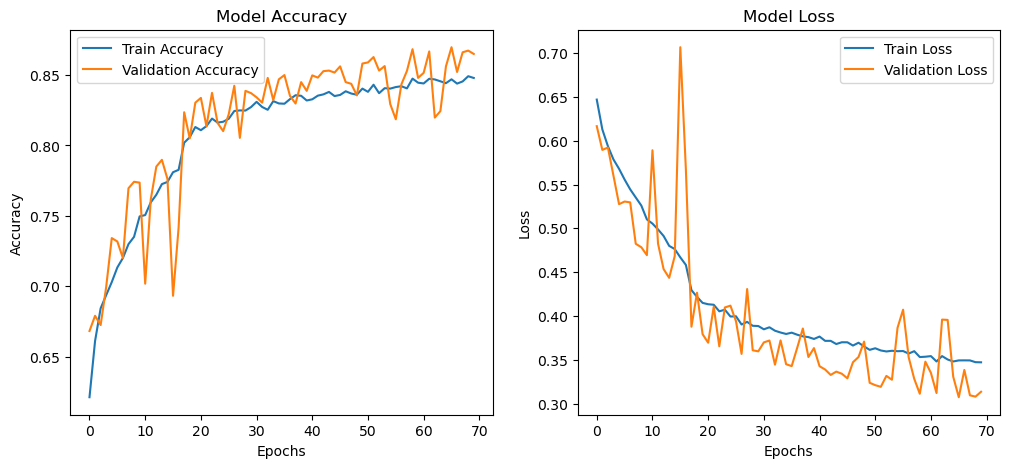

In [10]:
import matplotlib.pyplot as plt

# Assuming 'history' is the history object returned by model.fit()
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.show()

plot_metrics(history)


2025-02-05 04:51:34.781930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


157/157 [==============================] - 17s 108ms/step


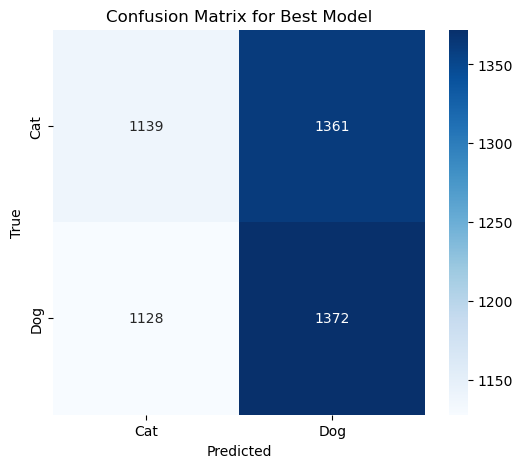

Classification Report:
              precision    recall  f1-score   support

         Cat       0.50      0.46      0.48      2500
         Dog       0.50      0.55      0.52      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model

# Load the best model saved after epoch 66
best_model = load_model('model_epoch_66.h5')

# Get predictions
y_pred_probs = best_model.predict(validation_ds)  # Predictions as probabilities
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()  # Convert to binary classes (0 or 1)

# Get true labels from validation dataset
y_true_classes = validation_ds.classes  # Extract true labels

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Best Model")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Cat', 'Dog']))


In [16]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [ ]:
test_img = cv2.imread('/home/zianraian/Downloads?/Test1') #upload the test picture

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img.shape

In [ ]:
test_img = cv2.resize(test_img, (256,256))

In [ ]:
test_input = test_img.reshape((1,256,256,3))

In [ ]:
model.prediction(test_img)